In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import datetime as dt


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

from tensorflow import keras

In [2]:
df1 = pd.read_csv('365_student_info.csv')
df2 =pd.read_csv('365_student_purchases.csv') 
df3 =pd.read_csv('365_student_engagement.csv') 
df4 =pd.read_csv('365_student_exams.csv') 
df5 =pd.read_csv('365_student_hub_questions.csv') 
df6 =pd.read_csv('365_student_learning.csv') 

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35230 entries, 0 to 35229
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   student_id       35230 non-null  int64 
 1   student_country  35217 non-null  object
 2   date_registered  35230 non-null  object
dtypes: int64(1), object(2)
memory usage: 825.8+ KB


In [3]:
df1 = df1[pd.notnull(df1['student_country'])]

In [4]:
df2

,purchase_id,student_id,purchase_type,date_purchased
0,15781,258800,Annual,2022-01-01
1,15786,258803,Annual,2022-01-01
2,15808,258862,Annual,2022-01-01
3,15809,258865,Annual,2022-01-01
4,15811,258878,Annual,2022-01-01
...,...,...,...,...
3036,23148,278055,Monthly,2022-10-20
3037,23150,270103,Annual,2022-10-20
3038,23151,270824,Monthly,2022-10-20
3039,23152,295497,Monthly,2022-10-20


In [5]:
df2_new= df2.groupby('student_id').agg(date_purchased = ('date_purchased', 'min')).reset_index() # min not max
len(df2_new['student_id'])

2135

# Data Combination

In [6]:
full_data = df1.merge(df2_new, on= 'student_id', how = 'left')
full_data.head()
len(full_data['student_id'])

35217

In [7]:
full_data['variance_days_register_and_purchase'] = (full_data['date_purchased'].apply(pd.to_datetime) - full_data['date_registered'].apply(pd.to_datetime)).dt.days


In [8]:
var = full_data[pd.notnull(full_data['variance_days_register_and_purchase'])] 

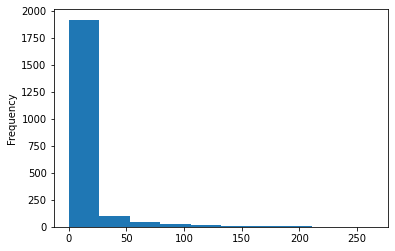

In [9]:
var['variance_days_register_and_purchase'].plot(kind='hist', bins = 10)

In [10]:
df3_new = df3.groupby('student_id').agg(engagement_quizzes = ('engagement_quizzes', 'sum'),
                                        engagement_exams = ('engagement_exams', 'sum'),
                                        engagement_lessons = ('engagement_lessons', 'sum'),).reset_index()

In [11]:
full_data = full_data.merge(df3_new[['engagement_quizzes', 'engagement_exams', 'engagement_lessons', 'student_id']], on= 'student_id', how = 'left')


In [12]:
df4 = df4.merge(df2[['student_id', 'date_purchased']], on= 'student_id', how = 'left')
df4.head()

,exam_attempt_id,student_id,exam_id,exam_result,exam_completion_time,date_exam_completed,date_purchased
0,173311,258803,475,83,5.17,2022-01-01,2022-01-01
1,173332,258815,380,0,10.02,2022-01-01,NaN
2,173333,258815,380,67,7.93,2022-01-01,NaN
3,173335,258815,380,100,0.60,2022-01-01,NaN
4,173336,258815,380,0,10.02,2022-01-01,NaN


In [13]:
df4_pur = df4[pd.notnull(df4['date_purchased'])]
df4_pur['exam vr pur days'] = (df4_pur['date_purchased'].apply(pd.to_datetime) - df4_pur['date_exam_completed'].apply(pd.to_datetime)).dt.days
df4_pur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,exam_attempt_id,student_id,exam_id,exam_result,exam_completion_time,date_exam_completed,date_purchased,exam vr pur days
0,173311,258803,475,83,5.17,2022-01-01,2022-01-01,0
5,173353,258822,415,0,10.00,2022-01-01,2022-01-09,8
6,173416,258862,368,50,3.93,2022-01-01,2022-01-01,0
7,173417,258862,368,50,1.25,2022-01-01,2022-01-01,0
8,173418,258862,368,50,1.08,2022-01-01,2022-01-01,0
...,...,...,...,...,...,...,...,...
49203,240391,293207,712,67,4.17,2022-10-20,2022-10-06,-14
49205,240398,269110,684,83,1.97,2022-10-20,2022-09-28,-22
49207,240401,269110,685,67,2.63,2022-10-20,2022-09-28,-22
49209,240406,282935,714,67,4.55,2022-10-20,2022-07-29,-83


In [14]:
labels_2 = [0,1]
df4_pur['bofore purchase'] = pd.cut(df4_pur['exam vr pur days'], 
                                bins=[-365 , 0, 365],
                                labels = labels_2)

df4_pur = df4_pur[df4_pur['bofore purchase'] == 1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
df4_pur_group= df4_pur.groupby('student_id').agg(total_exams_before_pur=('exam_id', 'count'), avg_exam_result_before_pur = ('exam_id', 'mean')).reset_index()
df4_pur_group.head()

,student_id,total_exams_before_pur,avg_exam_result_before_pur
0,258822,1,415.000000
1,258913,11,374.454545
2,258930,5,369.000000
3,258956,22,504.409091
4,258971,2,368.000000


In [16]:
df4_all= df4.groupby('student_id').agg(total_exams_all=('exam_id', 'count'), avg_exam_result_all = ('exam_id', 'mean')).reset_index()
df4_all.head()

,student_id,total_exams_all,avg_exam_result_all
0,258800,8,388.750000
1,258803,7,465.857143
2,258815,4,380.000000
3,258818,11,434.454545
4,258822,13,419.076923


In [17]:
full_data = full_data.merge(df4_pur_group[['total_exams_before_pur', 'avg_exam_result_before_pur', 'student_id']], on= 'student_id', how = 'left')
full_data = full_data.merge(df4_all[['total_exams_all', 'avg_exam_result_all', 'student_id']], on= 'student_id', how = 'left')
full_data.head()

,student_id,student_country,date_registered,date_purchased,variance_days_register_and_purchase,engagement_quizzes,engagement_exams,engagement_lessons,total_exams_before_pur,avg_exam_result_before_pur,total_exams_all,avg_exam_result_all
0,258798,IN,2022-01-01,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN
1,258799,CO,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,258800,CA,2022-01-01,2022-01-01,0.0,10.0,5.0,29.0,NaN,NaN,8.0,388.75
3,258801,IN,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,258802,US,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df5 = df5.merge(df2[['student_id', 'date_purchased']], on= 'student_id', how = 'left')
df5.head()

,hub_question_id,student_id,date_question_asked,date_purchased
0,7619,258803,2022-01-03,2022-01-01
1,7630,258803,2022-01-04,2022-01-01
2,7662,259342,2022-01-05,NaN
3,7667,259391,2022-01-05,NaN
4,7668,259174,2022-01-05,2022-01-07


In [19]:
df5_pur = df5[pd.notnull(df5['date_purchased'])]
df5_pur['quest vs pur days'] = (df5_pur['date_purchased'].apply(pd.to_datetime) - df5_pur['date_question_asked'].apply(pd.to_datetime)).dt.days
df5_pur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,hub_question_id,student_id,date_question_asked,date_purchased,quest vs pur days
0,7619,258803,2022-01-03,2022-01-01,-2
1,7630,258803,2022-01-04,2022-01-01,-3
4,7668,259174,2022-01-05,2022-01-07,2
5,7669,259174,2022-01-05,2022-01-07,2
6,7684,258818,2022-01-06,2022-01-03,-3
...,...,...,...,...,...
1271,10384,289048,2022-10-19,2022-09-01,-48
1272,10386,287473,2022-10-19,2022-08-28,-52
1273,10387,287473,2022-10-19,2022-08-28,-52
1275,10404,274798,2022-10-20,2022-05-23,-150


In [20]:
labels_3 = [0,1]
df5_pur['bofore purchase'] = pd.cut(df5_pur['quest vs pur days'], 
                                bins=[-365 , 0, 365],
                                labels = labels_3)

df5_pur = df5_pur[df5_pur['bofore purchase'] == 1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [21]:
df5_pur_group= df5_pur.groupby('student_id').agg(total_questions_before_pur=('student_id', 'count')).reset_index()
df5_pur_group.head()

,student_id,total_questions_before_pur
0,259174,3
1,259283,2
2,259860,2
3,260173,3
4,260465,31


In [22]:
df5_all= df5.groupby('student_id').agg(total_asked_questions=('student_id', 'count')).reset_index()
df5_all.head()

,student_id,total_asked_questions
0,258803,2
1,258818,1
2,258822,2
3,259174,14
4,259262,1


In [23]:
full_data = full_data.merge(df5_pur_group[['total_questions_before_pur', 'student_id']], on= 'student_id', how = 'left')
full_data = full_data.merge(df5_all[['total_asked_questions','student_id']], on= 'student_id', how = 'left')
full_data.head()

,student_id,student_country,date_registered,date_purchased,variance_days_register_and_purchase,engagement_quizzes,engagement_exams,engagement_lessons,total_exams_before_pur,avg_exam_result_before_pur,total_exams_all,avg_exam_result_all,total_questions_before_pur,total_asked_questions
0,258798,IN,2022-01-01,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,258799,CO,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,258800,CA,2022-01-01,2022-01-01,0.0,10.0,5.0,29.0,NaN,NaN,8.0,388.75,NaN,NaN
3,258801,IN,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,258802,US,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df6_pur = df6.merge(df2[['student_id', 'date_purchased']], on= 'student_id', how = 'left')
df6_pur = df6_pur[pd.notnull(df6_pur['date_purchased'])]
df6_pur['watch vs pur days'] = (df6_pur['date_purchased'].apply(pd.to_datetime) - df6_pur['date_watched'].apply(pd.to_datetime)).dt.days

In [25]:
labels_4 = [0,1]
df6_pur['bofore purchase'] = pd.cut(df6_pur['watch vs pur days'], 
                                bins=[-365 , 0, 365],
                                labels = labels_4)

df6_pur = df6_pur[df6_pur['bofore purchase'] == 1]

df6_pur_group= df6_pur.groupby('student_id').agg(total_watched_courses_before_pur=('course_id', 'count'),total_watched_minutes_before_pur=('minutes_watched', 'sum') ).reset_index()
df6_pur_group.head()

,student_id,total_watched_courses_before_pur,total_watched_minutes_before_pur
0,258822,1,0.1
1,258832,6,71.2
2,258913,4,358.9
3,258922,2,25.8
4,258930,9,142.6


In [26]:
df6_all = df6.groupby('student_id').agg(Total_watched_courses= ('course_id', 'count'), Total_watched_minutes= ('minutes_watched', 'sum')).reset_index()
df6_all.head()

,student_id,Total_watched_courses,Total_watched_minutes
0,258798,1,0.3
1,258800,29,531.2
2,258803,19,620.0
3,258804,1,14.2
4,258807,1,1.8


In [27]:
full_data = full_data.merge(df6_pur_group[['total_watched_courses_before_pur','total_watched_minutes_before_pur', 'student_id']], on= 'student_id', how = 'left')
full_data = full_data.merge(df6_all[['Total_watched_courses','Total_watched_minutes','student_id']], on= 'student_id', how = 'left')
full_data.head()

,student_id,student_country,date_registered,date_purchased,variance_days_register_and_purchase,engagement_quizzes,engagement_exams,engagement_lessons,total_exams_before_pur,avg_exam_result_before_pur,total_exams_all,avg_exam_result_all,total_questions_before_pur,total_asked_questions,total_watched_courses_before_pur,total_watched_minutes_before_pur,Total_watched_courses,Total_watched_minutes
0,258798,IN,2022-01-01,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.3
1,258799,CO,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,258800,CA,2022-01-01,2022-01-01,0.0,10.0,5.0,29.0,NaN,NaN,8.0,388.75,NaN,NaN,NaN,NaN,29.0,531.2
3,258801,IN,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,258802,US,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
full_data.fillna(0, inplace=True)

In [29]:
full_data['purchased']  = full_data['date_purchased'].apply(lambda x: 0  if x == 0 else 1)

In [30]:
full_data.drop(['student_country', 'date_registered', 'date_purchased', 'student_id'], inplace=True, axis=1)
full_data

,variance_days_register_and_purchase,engagement_quizzes,engagement_exams,engagement_lessons,total_exams_before_pur,avg_exam_result_before_pur,total_exams_all,avg_exam_result_all,total_questions_before_pur,total_asked_questions,total_watched_courses_before_pur,total_watched_minutes_before_pur,Total_watched_courses,Total_watched_minutes,purchased
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.3,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,10.0,5.0,29.0,0.0,0.0,8.0,388.75,0.0,0.0,0.0,0.0,29.0,531.2,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35212,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,7.8,0
35213,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,10.4,0
35214,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.1,0
35215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0


# Features Selection

In [31]:
data = full_data.copy()

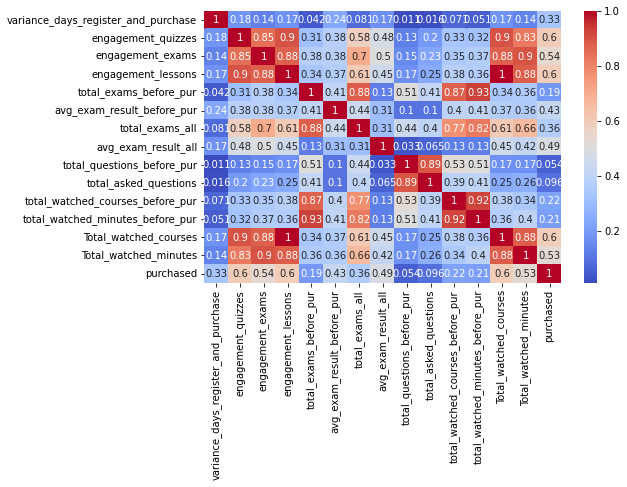

In [32]:
corr_matrix = data.corr()

plt.figure(figsize=( 8, 5 ))
sns.heatmap(corr_matrix, cmap= 'coolwarm', annot= True)

In [33]:
# drop low correlated features with 'purchased' column
data.drop(['total_exams_before_pur', 'total_questions_before_pur', 'total_asked_questions', 'total_watched_courses_before_pur','total_watched_minutes_before_pur'], inplace=True, axis=1)


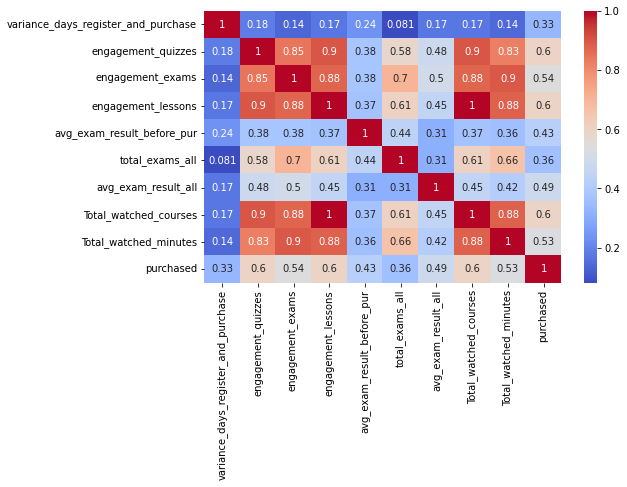

In [34]:
corr_matrix = data.corr()

plt.figure(figsize=( 8, 5 ))
sns.heatmap(corr_matrix, cmap= 'coolwarm', annot= True)

In [35]:
corr_matrix['purchased'].sort_values(ascending = False)

purchased                              1.000000
engagement_quizzes                     0.600657
Total_watched_courses                  0.596349
engagement_lessons                     0.596278
engagement_exams                       0.544072
Total_watched_minutes                  0.532787
avg_exam_result_all                    0.486379
avg_exam_result_before_pur             0.425261
total_exams_all                        0.363454
variance_days_register_and_purchase    0.334663
Name: purchased, dtype: float64

In [36]:
((data[data['purchased'] == 1].value_counts())/len(data)).sum() * 100

6.0595735014339684


### Students who purchased are contributing with ~ 6% of total students
### We can spot strong correlation between "engagement_quizzes" & "purchased" ... so, we will use it to make "Stratified Random Sampling"


In [37]:
# train and temp datasets

split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=42)
train_index, temp_index = next(split1.split(data, data.purchased , groups = data.engagement_quizzes))
strat_train_set = data.iloc[train_index]
strat_temp_set = data.iloc[temp_index]

#val and test datasets out of temp

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_index, test_index = next(split2.split(data, data.purchased , groups = data.engagement_quizzes))
strat_val_set = data.iloc[val_index]
strat_test_set = data.iloc[test_index]


In [38]:
X_train = strat_train_set[strat_train_set.columns[:-1]].values
y_train = strat_train_set[strat_train_set.columns[-1]].values

X_val = strat_val_set[strat_val_set.columns[:-1]].values
y_val = strat_val_set[strat_val_set.columns[-1]].values

X_test = strat_test_set[strat_test_set.columns[:-1]].values
y_test = strat_test_set[strat_test_set.columns[-1]].values

# Data Standardization

In [39]:
sc = StandardScaler()

X_train_sc = sc.fit_transform(X_train)
X_va_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

# Neural Network Model

In [40]:
model = keras.Sequential([
    keras.layers.Dense(32, activation = 'relu'),  
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(8, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid'),
])

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001),
              loss = keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy'])

In [41]:
model.evaluate(X_train_sc, y_train)

661/661 [==============================] - 1s 2ms/step - loss: 0.7353 - accuracy: 0.0636


[0.7352580428123474, 0.06360624730587006]

In [42]:
history = model.fit(X_train_sc, y_train, batch_size = 16, epochs= 20, validation_data= (X_va_sc, y_val))

Epoch 1/20
1321/1321 [==============================] - 6s 4ms/step - loss: 0.1130 - accuracy: 0.9706 - val_loss: 0.0730 - val_accuracy: 0.9796
Epoch 2/20
1321/1321 [==============================] - 4s 3ms/step - loss: 0.0712 - accuracy: 0.9808 - val_loss: 0.0702 - val_accuracy: 0.9817
Epoch 3/20
1321/1321 [==============================] - 5s 4ms/step - loss: 0.0690 - accuracy: 0.9818 - val_loss: 0.0659 - val_accuracy: 0.9825
Epoch 4/20
1321/1321 [==============================] - 4s 3ms/step - loss: 0.0671 - accuracy: 0.9823 - val_loss: 0.0651 - val_accuracy: 0.9831
Epoch 5/20
1321/1321 [==============================] - 4s 3ms/step - loss: 0.0665 - accuracy: 0.9823 - val_loss: 0.0643 - val_accuracy: 0.9831
Epoch 6/20
1321/1321 [==============================] - 5s 4ms/step - loss: 0.0657 - accuracy: 0.9831 - val_loss: 0.0641 - val_accuracy: 0.9828
Epoch 7/20
1321/1321 [==============================] - 4s 3ms/step - loss: 0.0656 - accuracy: 0.9832 - val_loss: 0.0636 - val_accuracy:

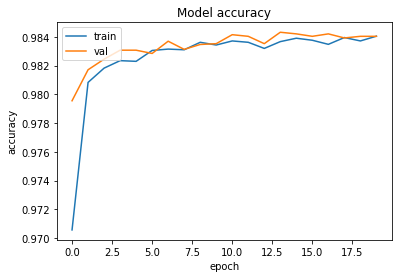

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

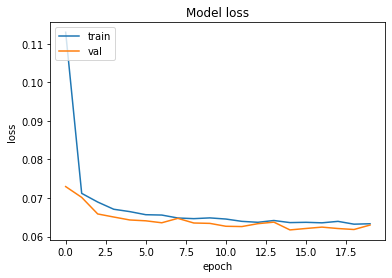

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [45]:
model.evaluate(X_test_sc, y_test)

551/551 [==============================] - 1s 2ms/step - loss: 0.0689 - accuracy: 0.9826


[0.06889335811138153, 0.9825657606124878]

# The End 😊